In [1]:
import os
import time

import numpy as np
import pandas as pd
import cv2
import pydicom
from skimage.transform import resize
import seaborn as sns
import matplotlib.pyplot as plt

### Exploration of the Pulmonary Fibrosis Competition Dataset

In [2]:
## Note Jupyter is ran from the "notebook" folder of this project
## Place data one folder up in a data folder, or modify imports location to run

DATA_DIR = '../data/osic-pulmonary-fibrosis-progression'
TRAIN_FOLDER = 'train'
VAL_FOLDER = 'test'
IMAGE_SIZE = (512, 512) ## image sizes used in training
IMAGE_SLICES = 8 ## slices used in training



### SNS defaults

In [3]:
sns.set_style("whitegrid")

### Some helpful functions

In [42]:
def get_dfs(base_dir, train_file='train', test_file='test', submission_file='sample_submission'):
    train = pd.read_csv('{base_dir}/{train_file}.csv'.format(base_dir=base_dir, train_file=train_file))
    validation = pd.read_csv('{base_dir}/{test_file}.csv'.format(base_dir=base_dir, test_file=test_file)) 
    submission = pd.read_csv('{base_dir}/{submission_file}.csv'.format(base_dir=base_dir, submission_file=submission_file)) 
    
    return train, validation, submission

def patient_image_count(base_dir, patient_ID, folder='train'):
    dir_list = os.listdir('{base_dir}/{folder}/{ID}/'.format(base_dir=base_dir, folder=folder, ID=patient_ID))
    return len(dir_list)

def get_images(base_dir, patient_ID, folder='train'):
    dir_list = os.listdir('{base_dir}/{folder}/{ID}/'.format(base_dir=base_dir, folder=folder, ID=patient_ID))
    file_count = len(dir_list)

    files = []
    for i in dir_list:
        d_img = pydicom.dcmread(f'{base_dir}/{folder}/{patient_ID}/{i}')
        files.append(d_img)
    
    return sorted(files, key=lambda s: s.SliceLocation)

def gif_3d(images, patient):
    for i in range(len(images)):
        print('saving image')
        img =images[i].pixel_array
        matplotlib.image.imsave(f'png_{patient}/img_{i}.png', img)
        
    frames = []
    files = []

    for png in list(os.listdir(f'png_{patient}')):
        files.append(png) 
    files.sort(key=lambda f: int(re.sub('\D', '', f)))
    
    for file in files:
        new_frame = Image.open(f'png_{patient}/' + file)
        frames.append(new_frame)

    # Save into a GIF file that loops forever
    frames[0].save(f'gif_{patient}.gif', format='GIF', append_images=frames[1:], save_all=True, duration=200, loop=0)

def print_image(image):
    slices = image['slices']
    img3d = image['img3d']
    img_shape = image['img_shape']
    
    ps = slices[0].PixelSpacing
    ss = slices[0].SliceThickness
    ax_aspect = ps[1]/ps[0]
    sag_aspect = ps[1]/ss
    cor_aspect = ss/ps[0]
    
    # plot 3 orthogonal slices
    a1 = plt.subplot(2, 2, 1)
    plt.imshow(img3d[:, :, img_shape[2]//2])
    a1.set_aspect(ax_aspect)

    a2 = plt.subplot(2, 2, 2)
    plt.imshow(img3d[:, img_shape[1]//2, :])
    a2.set_aspect(sag_aspect)

    a3 = plt.subplot(2, 2, 3)
    plt.imshow(img3d[img_shape[0]//2, :, :].T)
    a3.set_aspect(cor_aspect)

    plt.show()
    
def create_patient_image_from_slices(base_dir, patient_ID, folder='train', image_size=(512, 512)):
    bad_images = []

    slices = []
    dir_list = os.listdir('{base_dir}/{folder}/{ID}/'.format(base_dir=base_dir, folder=folder, ID=patient_ID))
    file_count = len(dir_list)

    # get file images based on subset
    error = False
    for i in dir_list:
        try:
            d_img = pydicom.dcmread(f'{base_dir}/{folder}/{patient_ID}/{i}')

            if hasattr(d_img, 'SliceLocation') and hasattr(d_img, 'pixel_array'):
                slices.append(d_img)
            else:
                raise

        except: 
            error = True
            print('error with ID ' + ID + ' on slice ' + str(k))
    
    image = None
    if error:
        bad_images.append(ID)
    else:
        ## ensure slices are in order
        slices = sorted(slices, key=lambda s: s.SliceLocation)          

        # create 3D array
        img_shape = (image_size[0], image_size[0], file_count)
        img3d = np.zeros(img_shape)

        # fill 3D array with the images from the files
        for i, s in enumerate(slices):
            img2d = resize(s.pixel_array, image_size)
            img3d[:, :, i] = img2d

        image = {
            'img_shape': img_shape,
            'img3d' : img3d,
            'slices': slices
        }
        
    return image, bad_images

### Datasets
There are three supplied datasets. Train, test, and submission.

##### From Kaggle competition description
- train.csv - the training set, contains full history of clinical information
- test.csv - the test set, contains only the baseline measurement
- train/ - contains the training patients' baseline CT scan in DICOM format
- test/ - contains the test patients' baseline CT scan in DICOM format
- sample_submission.csv - demonstrates the submission format

In [5]:
train, test, submission = get_dfs(DATA_DIR)

print('Training set shape:', train.shape)
print('Test set shape:', test.shape)
print('Submission set shape:', submission.shape)

Training set shape: (1549, 7)
Test set shape: (5, 7)
Submission set shape: (730, 3)


### Training and Test set headers

##### Headers
- Patient - (Categorical) - unique patient ID
- Weeks - (Numeric continuous) - Week of visit
- Percent - (Numeric continuous)
- FVC - (Numeric continuous) - patients baseline FVC
- Age - (Numeric continuous) - age at baseline visit
- Sex - (categorical) - male or female
- SmokingStatus - (categorical) - Ex-smoker, Currently smokes

### Test set exploration

In [6]:
test.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker
1,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker
2,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker
3,ID00423637202312137826377,17,3294,79.258903,72,Male,Ex-smoker
4,ID00426637202313170790466,0,2925,71.824968,73,Male,Never smoked


Test set consists of only 5 patients and their baseline measurements.

The ask is to use this set for testing, and predict all possible FVC values for weeks. (possible weeeks are talked about during submmision file exploration)

The final score will be based only on the final 3 weeks for each patient.

### Submission File Exploration
This file represents how prediction submissions should be entered into the competion.

This will be used as a template to prep submission.

NOTE: the competition asks for a confidence level of the prediction which is in (ml), same as the FVC

In [7]:
submission.head()

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,2000,100
1,ID00421637202311550012437_-12,2000,100
2,ID00422637202311677017371_-12,2000,100
3,ID00423637202312137826377_-12,2000,100
4,ID00426637202313170790466_-12,2000,100


In [8]:
patients = submission['Patient'] = submission['Patient_Week'].apply(lambda x: x.split('_')[0])
weeks = submission['Weeks'] = submission['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))

print('There are', len(patients.unique()), 'unique patients')
print('Weeks range from', weeks.min(), 'to', weeks.max())
print('It\'s noted that week 0 is the baseline CT scan. This appears at odds with the test set baselines.')
print('Negative weeks is because they may have had prior FVC readings.')
print('So the ask is to predict all weeks for these 5 patients from week', weeks.min(), 'to week', weeks.max())
print('FVC and confidence values in this file are placeholders.')

There are 5 unique patients
Weeks range from -12 to 133
It's noted that week 0 is the baseline CT scan. This appears at odds with the test set baselines.
Negative weeks is because they may have had prior FVC readings.
So the ask is to predict all weeks for these 5 patients from week -12 to week 133
FVC and confidence values in this file are placeholders.


### Training Set
This section focuses on the tabular (meta) data provided about the patients

In [9]:
train.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


### Check for NaNs

In [10]:
print('Missing values in dataset:', train.isnull().values.any())

Missing values in dataset: False


### Patient Distributions

In [11]:
print('Number of unique patients', len(train.Patient.unique()))

Number of unique patients 176


In [12]:
pivot = train.pivot_table(index=train.columns.to_list(), aggfunc='size')
print('There are', len(train.Patient) - len(pivot), 'duplicate rows')

There are 0 duplicate rows


In [13]:
train_unique = train.Patient.unique()
test_unique = test.Patient.unique()

count_of_crossover = 0
for p in test_unique:
    if p in train_unique:
        count_of_crossover += 1
        
print('There are', count_of_crossover, 'pateints from the test set in the train set')

There are 5 pateints from the test set in the train set


Our train set contains patients in our testing set!

May need to consider removing them.

Minimum visits from a single patient: 6
Max visits from a single patient: 10
Average visits from a single patient: 8.801136363636363


[]

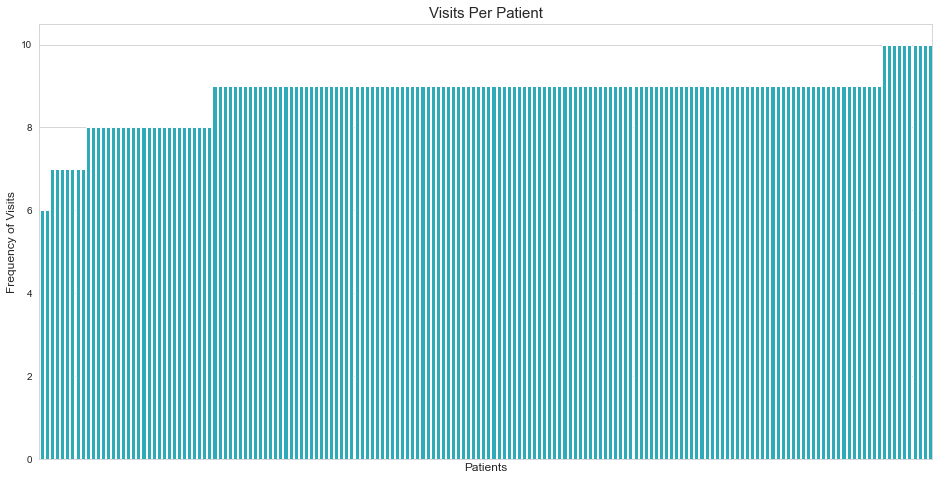

In [14]:
# patient visits
data = train.groupby(by='Patient')['Weeks'].count().reset_index(drop=False)
min_weeks = data.Weeks.min()
max_weeks = data.Weeks.max()
mean_weeks = data.Weeks.mean()

print('Minimum visits from a single patient:', min_weeks)
print('Max visits from a single patient:', max_weeks)
print('Average visits from a single patient:', mean_weeks)

data = data.sort_values(['Weeks']).reset_index(drop=True)
plt.figure(figsize = (16, 8))
p = sns.barplot(x=data["Patient"], y=data["Weeks"],  color=sns.color_palette()[-1])

plt.title("Visits Per Patient", fontsize = 15)
plt.xlabel('Patients', fontsize=12)
plt.ylabel('Frequency of Visits', fontsize=12)
p.axes.get_xaxis().set_ticks([])

Mean AWeeks: 31.861846352485475
Standard Deviation: 23.240045178171002


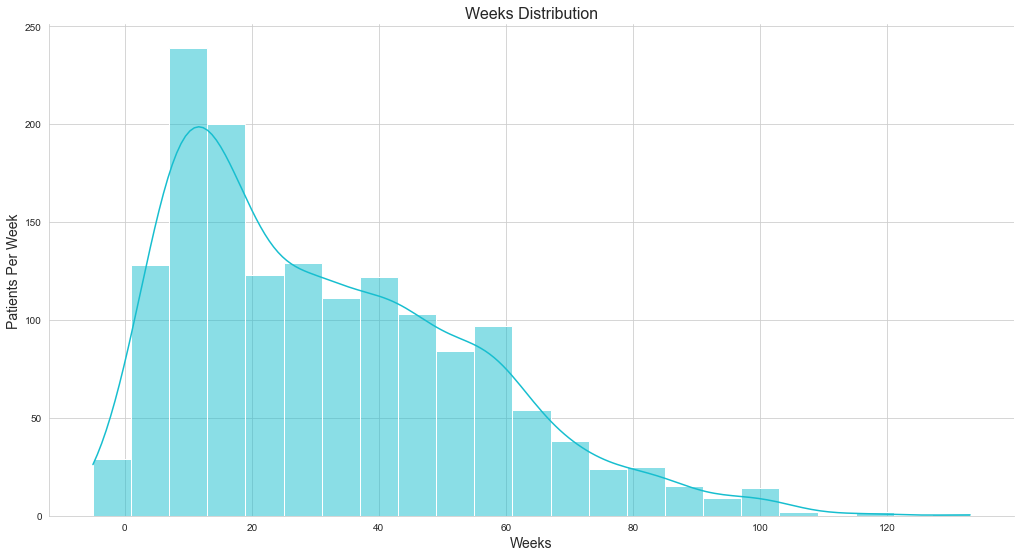

In [15]:
print('Mean AWeeks:', np.mean(train['Weeks']))
print('Standard Deviation:', np.std(train['Weeks']))

a = sns.displot(x=train['Weeks'], color=sns.color_palette()[-1], kde=True)
plt.title("Weeks Distribution", fontsize = 16)
plt.ylabel("Patients Per Week", fontsize=14);
plt.xlabel("Weeks", fontsize=14);
fig = plt.gcf()
fig.set_size_inches(16, 8)

Mean Age: 67.18850871530019
Standard Deviation: 7.055116199848975


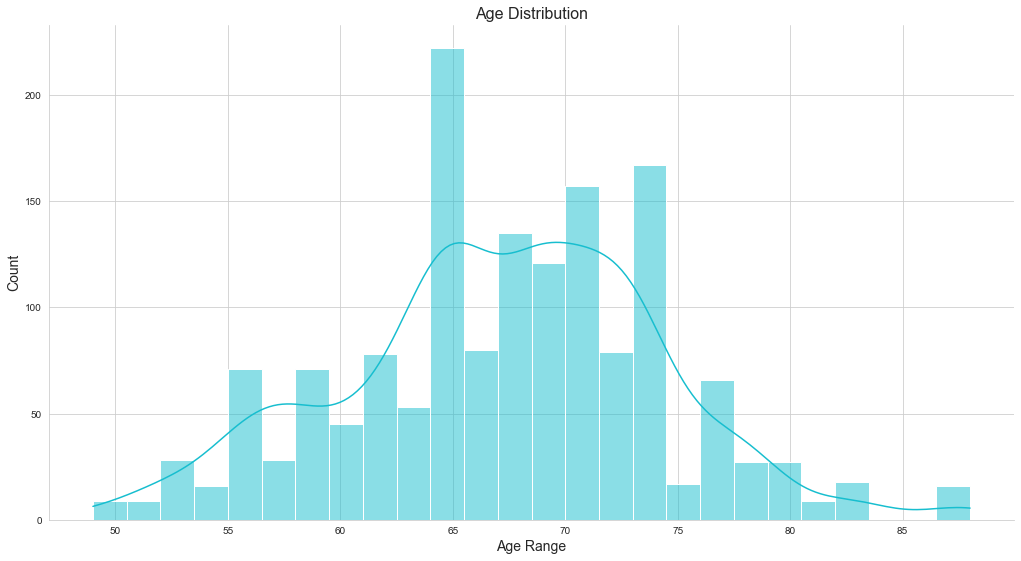

In [16]:
print('Mean Age:', np.mean(train['Age']))
print('Standard Deviation:', np.std(train['Age']))

a = sns.displot(x=train['Age'], color=sns.color_palette()[-1], kde=True)
plt.title('Age Distribution', fontsize = 16)
plt.ylabel("Count", fontsize=14);
plt.xlabel('Age Range', fontsize=14);
fig = plt.gcf()
fig.set_size_inches(16, 8)

Mean FVC: 2690.479018721756
Standard Deviation: 832.5021066817238


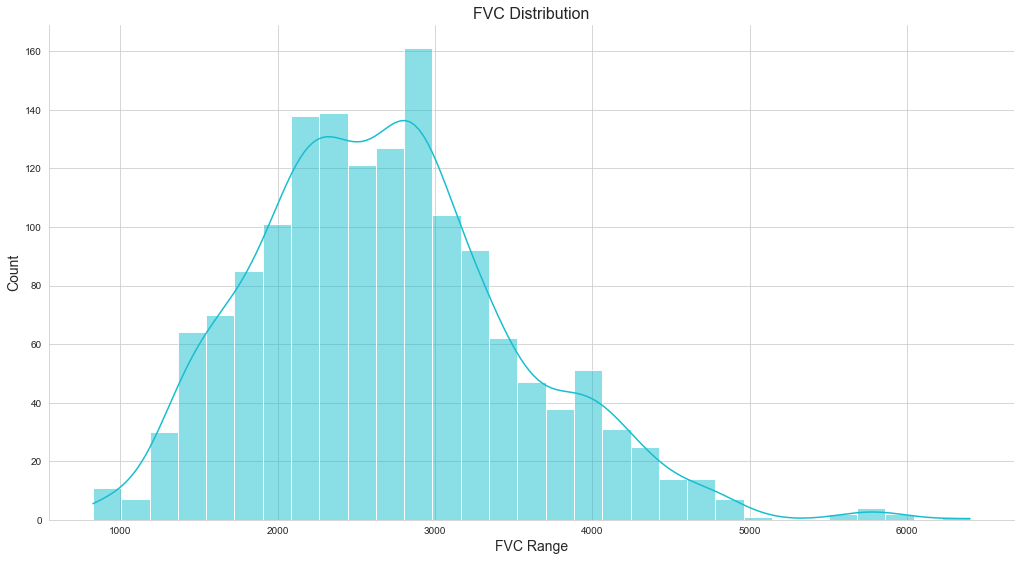

In [17]:
print('Mean FVC:', np.mean(train['FVC']))
print('Standard Deviation:', np.std(train['FVC']))

a = sns.displot(x=train['FVC'], color=sns.color_palette()[-1], kde=True)
plt.title('FVC Distribution', fontsize = 16)
plt.ylabel("Count", fontsize=14);
plt.xlabel('FVC Range', fontsize=14);
fig = plt.gcf()
fig.set_size_inches(16, 8)

Mean Percent: 77.67265350296326
Standard Deviation: 19.81686156299212


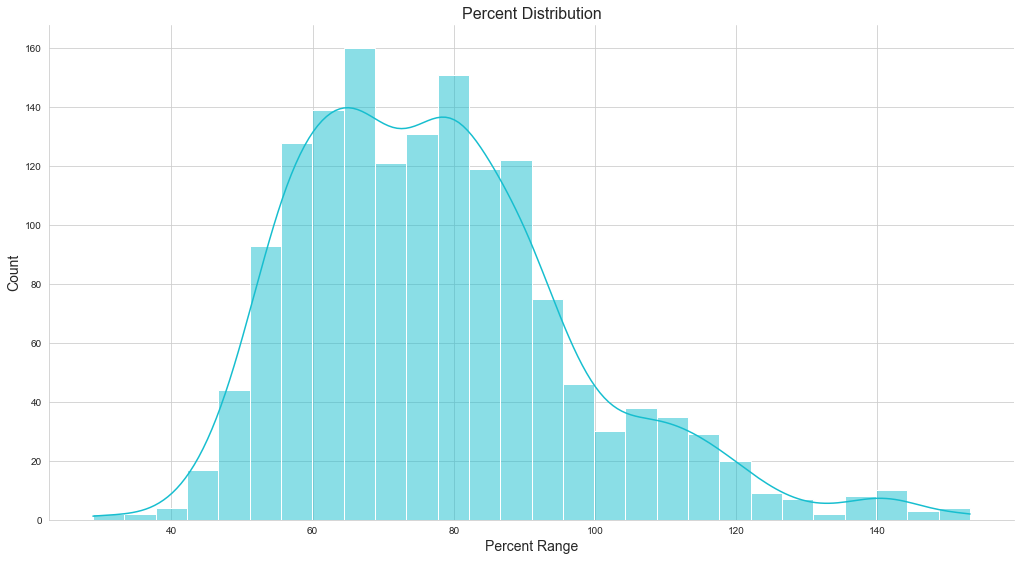

In [18]:
print('Mean Percent:', np.mean(train['Percent']))
print('Standard Deviation:', np.std(train['Percent']))

a = sns.displot(x=train['Percent'], color=sns.color_palette()[-1], kde=True)
plt.title('Percent Distribution', fontsize = 16)
plt.ylabel("Count", fontsize=14);
plt.xlabel('Percent Range', fontsize=14);
fig = plt.gcf()
fig.set_size_inches(16, 8)

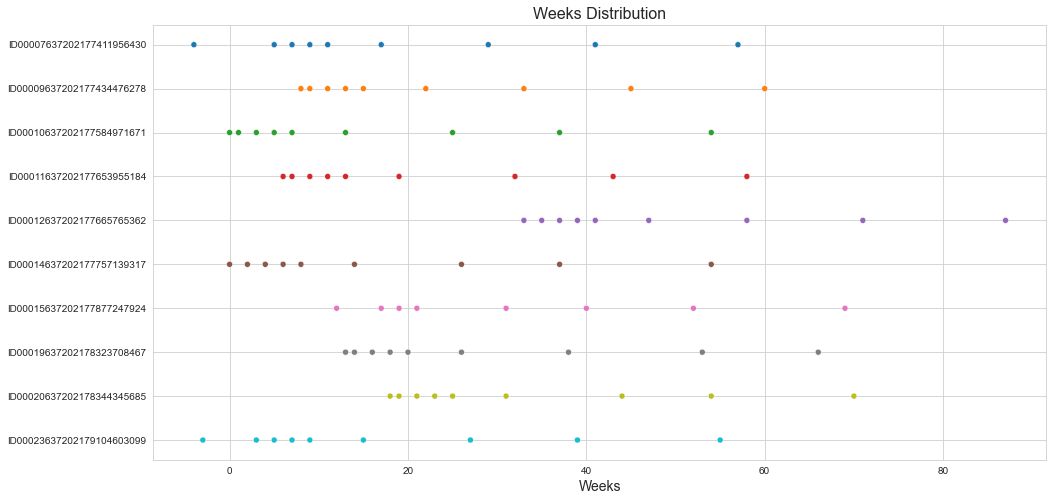

In [19]:
## gaps in visits
frames = {}
for patient, visit in zip(train["Patient"], train["Weeks"]):
    if patient not in frames:
        frames[patient] = []
    frames[patient].append(visit)

keys = list(frames.keys())
patients = []
weeks = []
for i in range(0,10):
    id_repeat = np.repeat(keys[i], len(frames[keys[i]]))
    [patients.append(k) for k in id_repeat]
    weeks = weeks + frames[keys[i]]


plt.figure(figsize = (16, 8))
p = sns.scatterplot(x=weeks, y=patients, hue=patients)
plt.title("Weeks Distribution", fontsize = 16)
plt.xlabel("Weeks", fontsize=14);
p.legend_.remove()

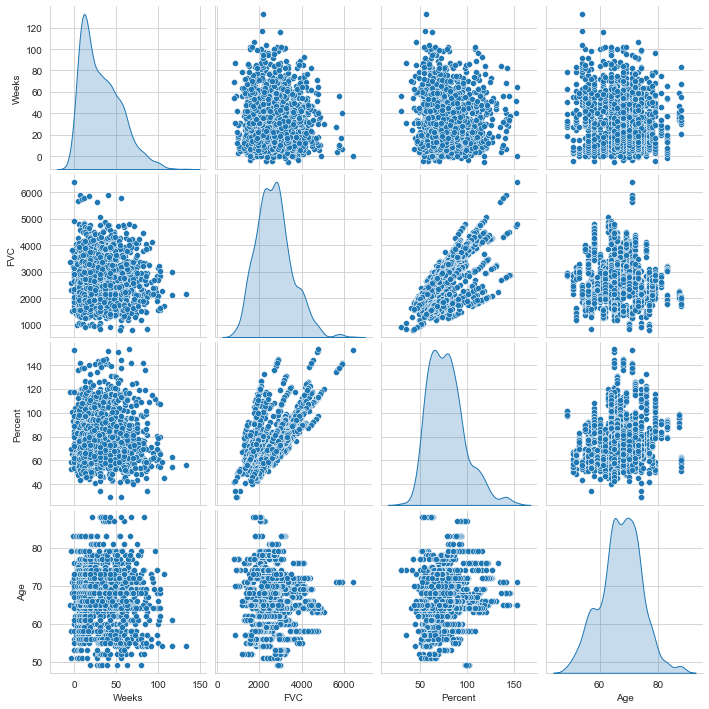

In [20]:
sns.pairplot(train, diag_kind='kde')

Text(0, 0.5, 'Counts')

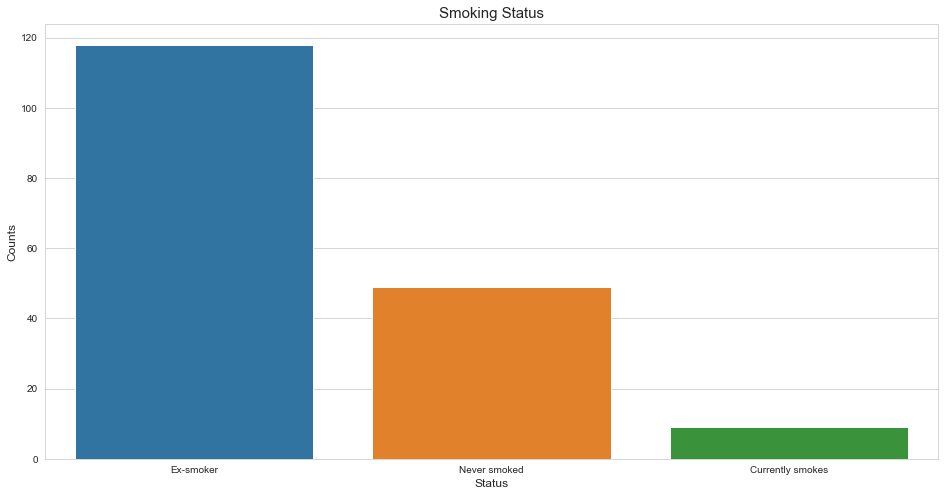

In [21]:
## histogram of smoking category
smoke_data = train.groupby(by='Patient')[['SmokingStatus']].first().reset_index(drop=True)

plt.figure(figsize = (16, 8))
sns.countplot(x=smoke_data['SmokingStatus'], palette=sns.color_palette()[0:3])
plt.title('Smoking Status', fontsize = 15)
plt.xlabel('Status', fontsize=12)
plt.ylabel('Counts', fontsize=12)

Text(0, 0.5, 'Counts')

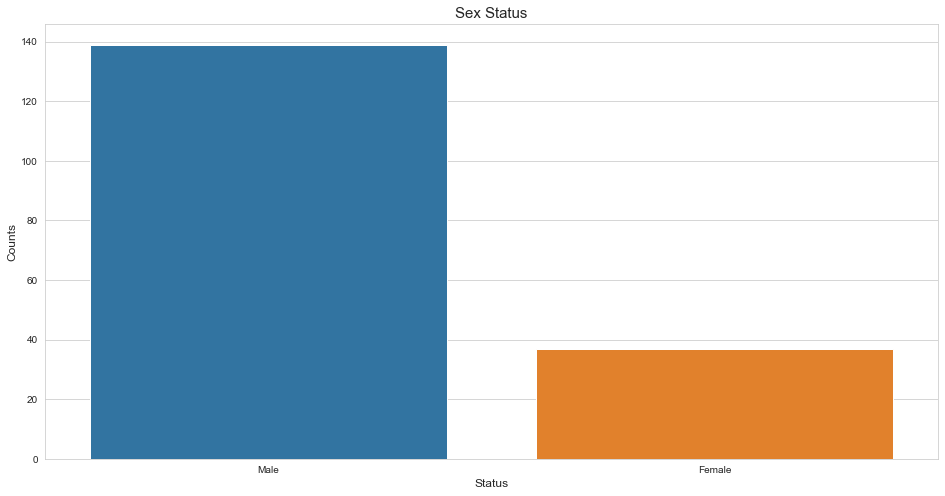

In [22]:
## histogram of sex
sex_data = train.groupby(by='Patient')[['Sex']].first().reset_index(drop=True)

plt.figure(figsize = (16, 8))
sns.countplot(x=sex_data['Sex'], palette=sns.color_palette()[0:3])
plt.title('Sex Status', fontsize = 15)
plt.xlabel('Status', fontsize=12)
plt.ylabel('Counts', fontsize=12)

C:\Users\mattb\anaconda3\envs\thesis\lib\site-packages\numpy\linalg\linalg.py:1965: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff


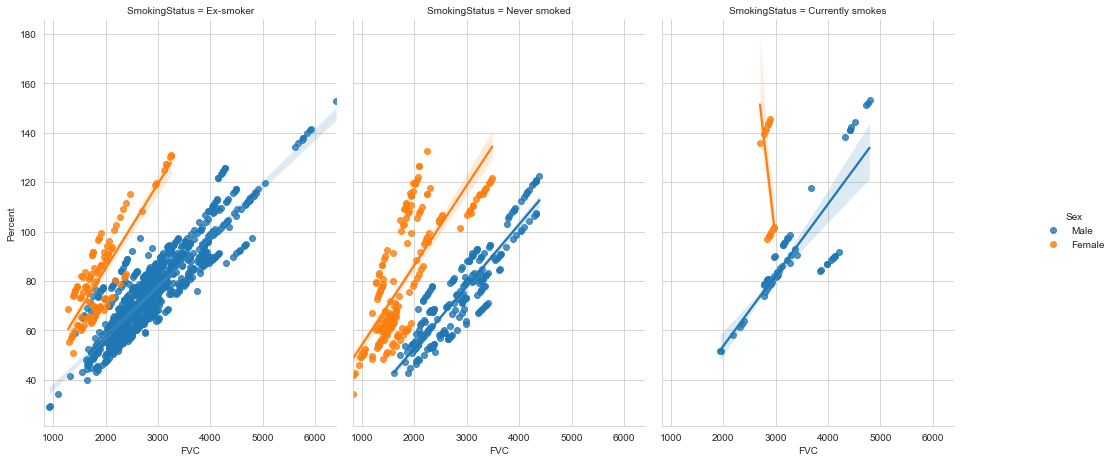

In [23]:
g = sns.FacetGrid(train, col='SmokingStatus', margin_titles=True, hue='Sex')
g.map(sns.regplot, 'FVC', 'Percent', fit_reg=True, x_jitter=.1)
g.add_legend()
fig = plt.gcf()
fig.set_size_inches(16, 8)

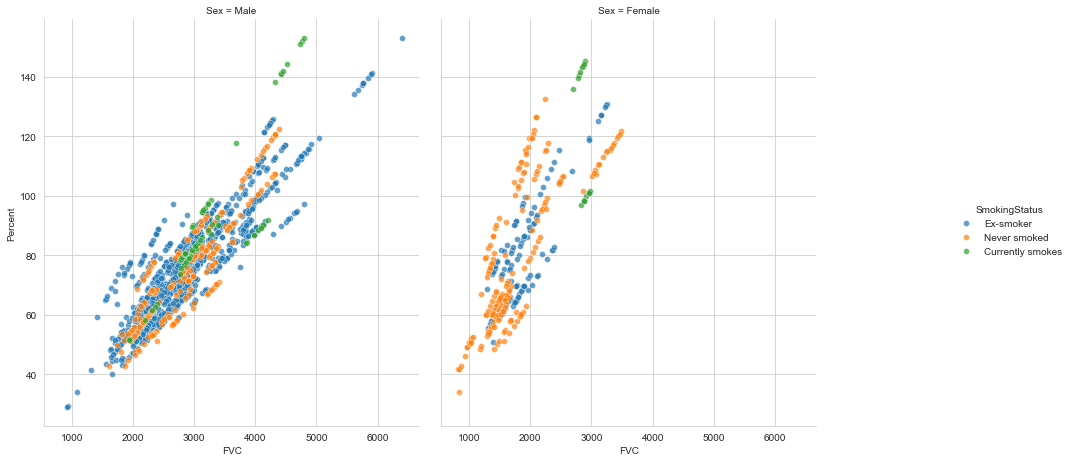

In [24]:
g = sns.FacetGrid(train, col='Sex', hue='SmokingStatus')
g.map(sns.scatterplot, 'FVC', 'Percent', alpha=.7)
g.add_legend()
fig = plt.gcf()
fig.set_size_inches(16, 8)

### Images

In [25]:
patient_keys = list(train.Patient.unique())
example_image, bad_images = create_patient_image_from_slices(DATA_DIR, patient_keys[0], folder='train', image_size=(512, 512))

print('Image Shape:', np.array(example_image['img3d']).shape)

Image Shape: (512, 512, 30)


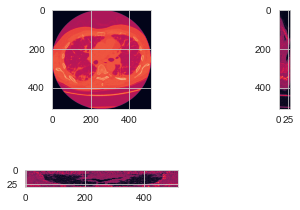

In [26]:
print_image(example_image)

In [27]:
from PIL import Image
from IPython.display import Image as show_gif
import scipy.misc
import matplotlib
import re

In [43]:
images = get_images(DATA_DIR, patient_keys[0])
gif_3d(images, patient_keys[0])
#show_gif(filename='./gif_' + patient_keys[0] + '.gif', format='png', width=400, height=400)

saving image


FileNotFoundError: [Errno 2] No such file or directory: 'png_ID00007637202177411956430/img_0.png'

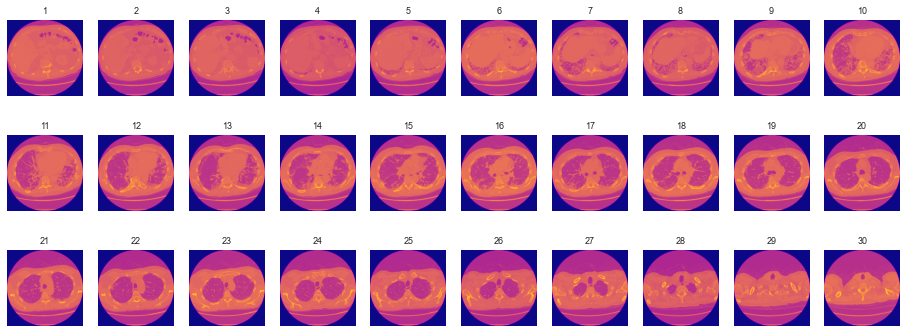

In [31]:
# Plot the images
fig=plt.figure(figsize=(16, 6))
columns = 10
rows = 3

for i in range(1, columns*rows +1):
    img = images[i-1].pixel_array
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap="plasma")
    plt.title(i, fontsize = 9)
    plt.axis('off');

In [32]:
### finally lets get a distribution of scans per patient
counts = []

for p in patient_keys:
    count = patient_image_count(DATA_DIR, p, folder='train')
    counts.append(count)

count_dict = {
    'Patient': patient_keys,
    'image_counts': counts
}

image_df = pd.DataFrame(count_dict)
image_df = image_df.sort_values(by=['image_counts'])

In [33]:
image_df.head()

,Patient,image_counts
70,ID00165637202237320314458,12
107,ID00248637202266698862378,16
54,ID00126637202218610655908,17
99,ID00229637202260254240583,17
90,ID00214637202257820847190,18


Median slices: 98.0
Mean slices: 187.64772727272728
Min slices: 12
Max slices: 1018


[]

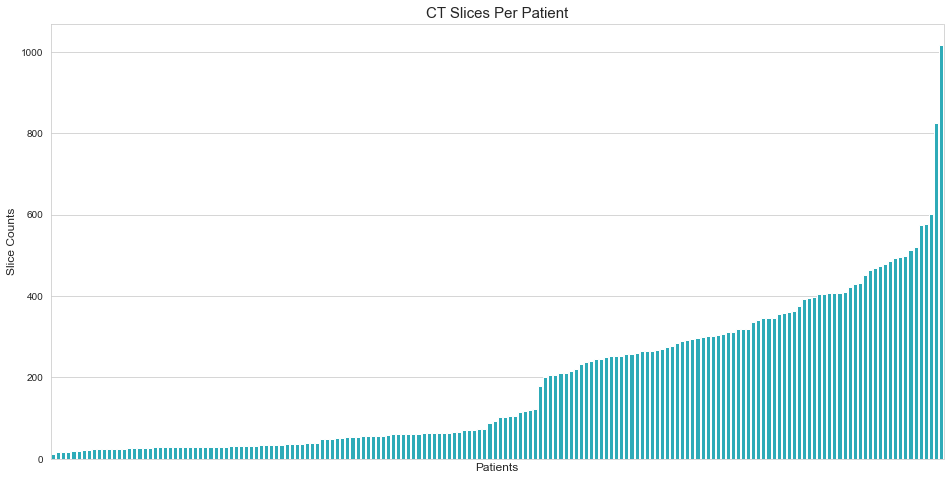

In [34]:
print('Median slices:', np.median(image_df['image_counts']))
print('Mean slices:', np.mean(image_df['image_counts']))
print('Min slices:', np.min(image_df['image_counts']))
print('Max slices:', np.max(image_df['image_counts']))

plt.figure(figsize = (16, 8))
p = sns.barplot(x=image_df['Patient'], y=image_df['image_counts'],  color=sns.color_palette()[-1])

plt.title("CT Slices Per Patient", fontsize = 15)
plt.xlabel('Patients', fontsize=12)
plt.ylabel('Slice Counts', fontsize=12)
p.axes.get_xaxis().set_ticks([])